In [42]:
import os
import posixpath
import ntpath
import os.path as p

import numpy as np
from sklearn.datasets import load_files       

from keras.preprocessing import image                  
from tqdm import tqdm

from keras.layers import GlobalAveragePooling2D
from keras.layers import Dropout, Dense
from keras.models import Sequential

In [ ]:
def extract_Xception(tensor, xception_model=None):
    if xception_model is None:
        from keras.applications.xception import Xception, preprocess_input
        #не оч решение каждый раз загружать тут модельку(долго будет), поэтому лучше передавать её
        xception_model = Xception(weights='imagenet', include_top=False)
    return xception_model.predict(preprocess_input(tensor))


def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [3]:
#model for dogs breeds

In [36]:
input_shape = (7, 7, 2048)
dogs_breeds = np.load('/home/vlad/Загрузки/catdogs/dog_breeds.npy')


def build_dogs_breeds_model(path_to_weights):
    dogs_breeds_model = Sequential()
    dogs_breeds_model.add(GlobalAveragePooling2D(input_shape=input_shape))
    dogs_breeds_model.add(Dropout(0.1))
    dogs_breeds_model.add(Dense(133, activation='softmax'))

    dogs_breeds_model.load_weights(path_to_weights)
    return dogs_breeds_model



In [37]:
dogs_breeds_model = build_dogs_breeds_model('/home/vlad/Загрузки/catdogs/weights.best.Xception_dogs2.hdf5')

def predict_dog_breed(img_path, top=1):
    # extract the bottle neck features
    bottleneck_feature = extract_Xception(path_to_tensor(img_path)) 
    ## get a vector of predicted values
    predicted_vector = dogs_breeds_model.predict(bottleneck_feature) 
    
    ## return the breed
    top_predictions = np.argpartition(predicted_vector[0], -top)[-top:]
    result = []
    for idx in top_predictions:
        result.append((dogs_breeds[idx], f'{predicted_vector[0][idx]:5.4f}'))
    return result[::-1]
    

In [40]:
predict_dog_breed('/home/vlad/Загрузки/catdogs/dogImages/valid/014.Basenji/Basenji_00960.jpg', top=3)

[('Basenji', '0.9987'),
 ('American_foxhound', '0.0005'),
 ('Smooth_fox_terrier', '0.0004')]

In [41]:
#same for cats breeds

In [49]:
cats_breeds = np.load('/home/vlad/Загрузки/catdogs/cat_breeds.npy')

def build_cats_breeds_model(path_to_weights):
    cats_breeds_model = Sequential()
    cats_breeds_model.add(GlobalAveragePooling2D(input_shape=input_shape))
    cats_breeds_model.add(Dropout(0.1))
    cats_breeds_model.add(Dense(67, activation='softmax'))

    cats_breeds_model.load_weights(path_to_weights)
    return cats_breeds_model


In [50]:
cats_breeds_model = build_cats_breeds_model('/home/vlad/Загрузки/catdogs/weights.best.Xception_cat.hdf5')

def predict_cat_breed(img_path, top=1):
    # extract the bottle neck features
    bottleneck_feature = extract_Xception(path_to_tensor(img_path)) 
    ## get a vector of predicted values
    predicted_vector = cats_breeds_model.predict(bottleneck_feature) 
    
    ## return the breed
    top_predictions = np.argpartition(predicted_vector[0], -top)[-top:]
    result = []
    for idx in top_predictions:
        result.append((cats_breeds[idx], f'{predicted_vector[0][idx]:5.4f}'))
    return result[::-1]

In [54]:
predict_cat_breed('/home/vlad/Загрузки/catdogs/catImages/images/Ocicat/24741737_395.jpg', top=3)

[('Ocicat', '0.8050'), ('Egyptian Mau', '0.1600'), ('Silver', '0.0102')]

In [55]:
#similar dog images


In [69]:
import pickle
from keras.preprocessing import image
from scipy.spatial import distance

import matplotlib.pyplot as plt

In [108]:
def get_dog_pca_files(path_to_pca, path_to_dogs_images):
    with open(path_to_pca, 'rb') as fp:
        pca_files = pickle.load(fp)
    pca_dogs_features = pca_files[0]
    pca_dogs = pca_files[1]
    
    dogs_images = load_files(path_to_dogs_images)
    dog_files = np.array(dogs_images['filenames'])
    return pca_dogs, pca_dogs_features, dog_files
    
def find_similar_images(path_to_image, pca, pca_features, files, top=5):
    img_features = extract_Xception(path_to_tensor(path_to_image)).reshape(1, -1)
    img_pca_features = pca.transform(img_features)

    similar_idx = [distance.cosine(img_pca_features, feat) for feat in pca_features]
    idx_closest = sorted(range(len(similar_idx)), key=lambda k: similar_idx[k])[0:top]
    return files[idx_closest]

In [101]:
pca_dogs, pca_dogs_features, dog_files = \
get_dog_pca_files('/home/vlad/Загрузки/catdogs/pca_dogs.p', '/home/vlad/Загрузки/catdogs/dogImages/train')

In [109]:
#вот так находим похожие, дальше картинки
random_dog_file = '/home/vlad/Загрузки/catdogs/dogImages/valid/027.Bloodhound/Bloodhound_01894.jpg'
similar_dogs = find_similar_images(random_dog_file, pca_dogs, pca_dogs_features, dog_files)

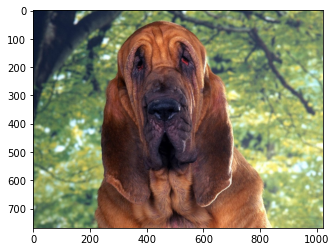

In [110]:
img = image.load_img(random_dog_file)
plt.imshow(img)


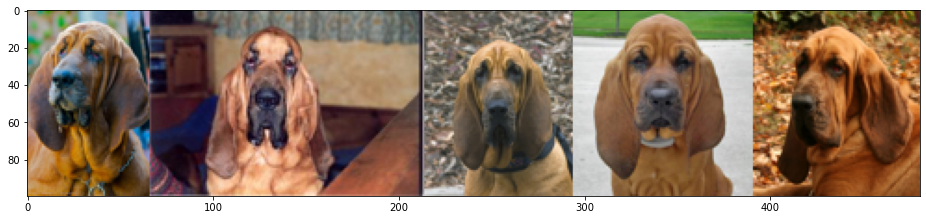

In [111]:
thumbs = []
for dog in similar_dogs:
    img = image.load_img(dog)
    img = img.resize((int(img.width * 100 / img.height), 100))
    thumbs.append(img)

# concatenate the images into a single image
concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)

# show the image
plt.figure(figsize = (16,12))
plt.imshow(concat_image)

In [ ]:
#same for cats

In [151]:

"""
fix path in cats images files

cats_images_folder - path to images as str
cats_filenames_file - path to numpy array with cats filenames as str
"""
def get_cats_filenames(cats_images_folder, cats_filenames_file):
    cats_filenames = np.load(cats_filenames_file)
    if os.name != 'posix':
        cats_filenames = [name.replace(os.sep, ntpath.sep) for name in cats_filenames]
    actual_cats_images_files = np.array(load_files(cats_images_folder)['filenames'])

    dataset_prefix = p.commonprefix(list(cats_filenames))
    actual_prefix = p.commonprefix(list(actual_cats_images_files))

    actual_filenames = [name.replace(dataset_prefix, actual_prefix) for name in cats_filenames]
    return np.array(actual_filenames)

In [135]:
def get_cat_pca_files(path_to_pca, path_to_cats_images, path_to_cat_images_array):
    with open(path_to_pca, 'rb') as fp:
        pca_files = pickle.load(fp)
    pca_cats_features = pca_files[0]
    pca_cats = pca_files[1]
    
    cat_files = get_cats_filenames(path_to_cats_images, path_to_cat_images_array)
    return pca_dogs, pca_cats_features, cat_files


In [136]:
pca_cats, pca_cats_features, cat_files = \
get_cat_pca_files('/home/vlad/Загрузки/catdogs/pca_cats.p', 
                  '/home/vlad/Загрузки/catdogs/catImages/images', 
                  '/home/vlad/Загрузки/catdogs/cat_files.npy')

In [148]:
random_cat_file = '/home/vlad/Загрузки/catdogs/catImages/images/Abyssinian/40526121_189.jpg'
similar_cats = find_similar_images(random_cat_file, pca_cats, pca_cats_features, cat_files)

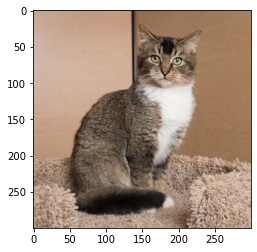

In [149]:
img = image.load_img(random_cat_file)
plt.imshow(img)


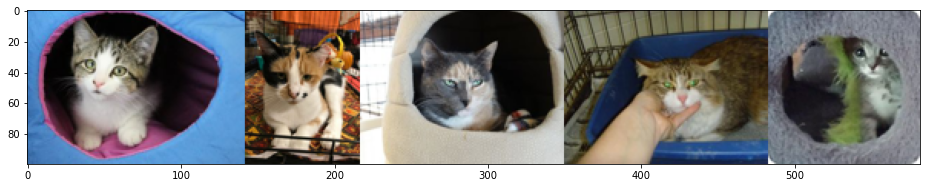

In [150]:
thumbs = []
for cat in similar_cats:
    img = image.load_img(cat)
    img = img.resize((int(img.width * 100 / img.height), 100))
    thumbs.append(img)

# concatenate the images into a single image
concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)

# show the image
plt.figure(figsize = (16,12))
plt.imshow(concat_image)